# Projet 5 - Catégorisez automatiquement des questions

## Importation des librairies et des données et conversions

In [45]:
import numpy as np
import pandas as pd
import gensim
import scipy
from sklearn.decomposition import LatentDirichletAllocation
import csv
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, plot_confusion_matrix
import joblib
from sklearn.model_selection import train_test_split

In [93]:
test_mx = pd.read_csv('test_mx.csv', sep=';', index_col=0)
train_mx = pd.read_csv('train_mx.csv', sep=';', index_col=0)
fw_dict = pd.read_csv('fw_dict.csv')
test_df = pd.read_csv('filtered_test_df.csv', sep=';',
                      index_col=0, converters={'processed_tags': eval})
train_df = pd.read_csv('filtered_df.csv', sep=';',
                       index_col=0, converters={'processed_tags': eval})

In [47]:
feature_name = []
with open('feature_name.csv', 'r') as data:
    for line in csv.reader(data):
        feature_name.append(line)

# Transforme la liste de listes en liste
feature_names = [item for sublist in feature_name for item in sublist]

In [50]:
fw_dict = fw_dict.to_dict(orient='list')

In [51]:
train_feature = scipy.sparse.csr_matrix(train_mx.values)

In [52]:
train_feature

<34802x997 sparse matrix of type '<class 'numpy.float64'>'
	with 1060544 stored elements in Compressed Sparse Row format>

## LDA

In [8]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(train_feature)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [9]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [10]:
n_top_words = 40
print("\nTopics in LDA model: ")
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model: 
Topic #0:
use javascript using would page like code way file j know html browser c jquery function window application one google need example time want image work question good java find script web chrome event used user library get net looking
Topic #1:
public thread class method exception static void task java catch private new system difference async throw test interface null println try return string block queue object code main call e final instance wait console boolean writeline args run override int
Topic #2:
java android org jar eclipse com gradle maven spring annotation dependency hibernate lang junit xml bean compile build support google plugin apache sun class project util internal springframework version activitythread servlet jdk test http main error source property v groupid
Topic #3:
android view layout button image activity app self color intent item text id io screen height swift fragment want width parent r background set change textview action 

## ACP

On extrait le 1er tag de chaque ligne pour créer 'y' de la base train et test. Il faut encoder les données sur le dataframe contenant toutes les données pour éviter des problèmes liés avec des tags qui apparaissent dans une base et non l'autre

### LabelEncoder

In [94]:
full_df = pd.concat([train_df, test_df])
pre_base = [full_df['processed_tags'].iloc[i][0]
            for i in range(len(full_df['processed_tags']))]
le = preprocessing.LabelEncoder()
le.fit(pre_base)

LabelEncoder()

In [95]:
pre_ytrain = [train_df['processed_tags'].iloc[i][0]
              for i in range(len(train_df['processed_tags']))]
y_train = le.transform(pre_ytrain)

In [97]:
pre_ytest = [test_df['processed_tags'].iloc[i][0]
             for i in range(len(test_df['processed_tags']))]
y_test = le.transform(pre_ytest)

In [98]:
# Normalisation de la base train
std_scale = preprocessing.StandardScaler().fit(train_mx)
X_scaled = std_scale.transform(train_mx)

In [99]:
# Normalisation de la base test selon la base test
X_scaled_test = std_scale.transform(test_mx)

On test l'ACP avec plusieurs nombres de composants

In [102]:
# On calcul les 2 premieres composantes principales
pca = decomposition.PCA(n_components=800).fit(X_scaled)

# projeter X sur les composantes principales
train_projected = pca.transform(X_scaled)

In [104]:
test_projected = pca.transform(X_scaled_test)

In [105]:
test_projected.shape

(8696, 800)

In [106]:
# Pourcentage de la variance expliquee
# print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

0.881514688185973


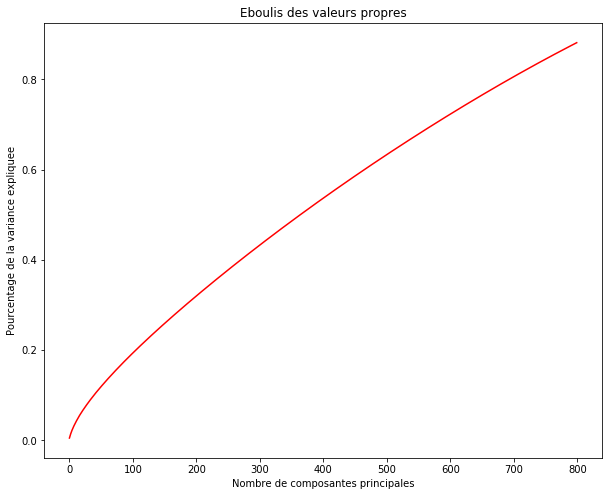

In [107]:
plt.figure(figsize=(10, 8))
scree = pca.explained_variance_ratio_*100
#plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree)), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Pourcentage de la variance expliquee')
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On enregistre les composantes dans une variable qui devient le nouveau x_train

In [108]:
train_projected.shape

(34802, 800)

### Exportation données

Exportation des données pour le fonctionnement de l'API

In [129]:
np.save('tags.npy', pre_ytrain)

In [101]:
joblib.dump(std_scale, 'std_scale.plk')

['std_scale.plk']

In [103]:
joblib.dump(pca, 'model_pca.plk')

['model_pca.plk']

## Modélisation

### Préparation des données

__Base initiale:__

In [109]:
X_train = train_projected
Y_train = y_train
X_test = test_projected
Y_test = y_test

Nous allons crée une nouvelle base test et train afin de pouvoir tester la modélisation avant de réaliser la validation du modèle final sur la base test initiale.

In [111]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(
    X_train, Y_train, test_size=0.20, random_state=42)

__Split base:__

In [90]:
X = X_train_2
Y = Y_train_2

In [91]:
print(X_train_2.shape)
print(Y_train_2.shape)

(27841, 800)
(27841,)


__Base échantillon:__

Pour tester le bon fonctionnement des modèles, nous avons créer une nouvelle base train-test_E à partir des 10 000 première valeurs de X_train et Y_train. Cela permet de pouvoir faire tourner les algorithmes plus facilement.

In [92]:
X_train_E, X_test_E, Y_train_E, Y_test_E = train_test_split(
    X_train[:10000], Y_train[:10000], test_size=0.20, random_state=42)

### V1 - Modélisation sur un échantillon

Nous allons tester trois modèles différents pour trouver celui ayant la meilleure précision. Les trois modèles choisis sont:
- l'arbre de décision
- le modèle logisitique
- la SVM

 Ces tests sont effectués sur un échantillon de données pour pouvoir faire exécuter les modèles. Cependant le résultat de ces tests là ne sont pas pris en compte dans le choix du modèle final, ils permettent uniquement de vérifier le bon fonctionnement des modèles.

In [29]:
# Choix des données d'entrainement
X = X_train_E
Y = Y_train_E

### Arbre de décision

In [84]:
tree_class = DecisionTreeClassifier()
tree_class.fit(X, Y)

DecisionTreeClassifier()

In [85]:
Y_pred = tree_class.predict(X_test_E)

print(f1_score(Y_test_E, Y_pred, average='micro'))
print(precision_score(Y_test_E, Y_pred, average="macro"))
print(recall_score(Y_test_E, Y_pred, average="macro"))
print(classification_report(Y_test_E, Y_pred))

0.344
0.14479324281992892
0.1402413575967063
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           3       0.00      0.00      0.00         2
           5       0.52      0.52      0.52       187
          13       0.00      0.00      0.00         3
          23       0.27      0.38      0.31        34
          24       0.30      0.30      0.30       247
          26       0.42      0.37      0.40       148
          33       0.30      0.25      0.27        40
          38       0.00      0.00      0.00         2
          39       0.00      0.00      0.00         1
          49       0.73      0.69      0.71        65
          51       0.00      0.00      0.00         0
          55       0.20      0.21      0.21        56
          59       0.00      0.00      0.00         1
          63       0.33      0.27      0.30       100
          66       0.09      0.13      0.11        38
          70       0.34      0.38   

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: Undef

### Régression logistique

In [86]:
log_reg = LogisticRegression()
log_reg.fit(X, Y)

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [87]:
Y_pred = log_reg.predict(X_test_E)

print(f1_score(Y_test_E, Y_pred, average='micro'))
print(precision_score(Y_test_E, Y_pred, average="macro"))
print(recall_score(Y_test_E, Y_pred, average="macro"))
print(classification_report(Y_test_E, Y_pred))

0.5875
0.330346042482038
0.3147159592516945
              precision    recall  f1-score   support

           0       0.23      0.26      0.24        35
           3       0.00      0.00      0.00         2
           5       0.60      0.62      0.61       187
          13       0.00      0.00      0.00         3
          23       0.31      0.47      0.37        34
          24       0.59      0.65      0.62       247
          26       0.59      0.53      0.56       148
          33       0.47      0.38      0.42        40
          38       0.00      0.00      0.00         2
          39       0.00      0.00      0.00         1
          49       0.91      0.74      0.81        65
          55       0.37      0.39      0.38        56
          59       0.00      0.00      0.00         1
          63       0.62      0.55      0.59       100
          66       0.17      0.18      0.18        38
          70       0.59      0.65      0.62       230
          71       0.58      0.59    

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [88]:
svm = SVC()
svm.fit(X, Y)

SVC()

In [89]:
Y_pred = svm.predict(X_test_E)

print(f1_score(Y_test_E, Y_pred, average='micro'))
print(precision_score(Y_test_E, Y_pred, average="macro"))
print(recall_score(Y_test_E, Y_pred, average="macro"))
print(classification_report(Y_test_E, Y_pred))

0.6235
0.3903087821835974
0.2874000660722521
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           3       0.00      0.00      0.00         2
           5       0.73      0.76      0.74       187
          13       0.00      0.00      0.00         3
          23       0.75      0.18      0.29        34
          24       0.49      0.72      0.58       247
          26       0.76      0.61      0.67       148
          33       0.42      0.25      0.31        40
          38       0.00      0.00      0.00         2
          39       0.00      0.00      0.00         1
          49       0.83      0.69      0.76        65
          55       0.35      0.21      0.27        56
          59       0.00      0.00      0.00         1
          63       0.67      0.62      0.65       100
          66       1.00      0.08      0.15        38
          70       0.54      0.75      0.63       230
          71       0.54      0.77   

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Modélisation sur toutes les données

Une fois que nous avons vérifié que les modèles fonctionnent, les tests pour trouver le modèle le plus adapté sont lancés sur toutes les données.

### Tests sur google colab

Le jeu de données étant très important, j'ai rencontré des difficultées à faire tourner ces codes sur jupyter. J'ai donc fait certains tests sur google colab en utilisant le GPU. Pour pouvoir faire cela, il m'a fallu transférer les données sur google colab et vérifier leur forme et leur taille.

In [27]:
X = X_train_2
Y = Y_train_2

In [28]:
print(X.shape)
print(Y.shape)
print(X_test_2.shape)
print(Y_test_2.shape)

(27900, 800)
(27900,)
(6976, 800)
(6976,)


In [29]:
print('X:', X)
print('Y:', Y)
print('X_test_2:', X_test_2)
print('Y_test_2:', Y_test_2)

X: [[ 0.6308673  -1.29475411 -2.48500474 ... -1.57374487 -0.28336823
  -1.37927146]
 [-0.47473237 -1.2811054  -0.13240925 ... -0.85725817  0.27135341
   0.07065494]
 [-3.44883561  0.4801291  -1.097162   ... -0.62238276  0.02870844
  -2.86407701]
 ...
 [-0.60307577  1.32995904  1.60713454 ...  0.40832189  0.5182883
  -0.22438643]
 [ 0.03098465 -2.50835725  3.99099541 ...  0.97028402  0.32447122
  -0.59510646]
 [ 0.15557146  0.48820484 -0.30835538 ...  1.19139354  0.8639742
   1.84410017]]
Y: [71 90 90 ... 70 26 87]
X_test_2: [[ 4.10706023e+00 -1.35589932e+00 -3.85813274e+00 ...  4.20535336e-01
  -1.25037205e+00 -1.29945165e+00]
 [ 1.53820732e+00  6.53139347e-03 -6.72654005e-01 ... -1.06890883e-02
  -1.11226497e+00 -7.68421269e-02]
 [-3.51798866e+00  1.03986573e+00 -1.13900036e+00 ...  5.22231805e-01
  -6.74840348e-01  1.43773371e+00]
 ...
 [-7.61737691e-01 -1.36831669e+00  3.27620734e+00 ...  3.55936404e-01
  -1.46203278e+00 -4.76016808e-02]
 [-1.93316048e+00 -1.49257989e+00  4.67835337

In [74]:
# Sauvegarde des données pour utiliser dans google colab
np.savetxt('X.csv', X, delimiter=',', fmt='%d', header='Values')
np.savetxt('Y.csv', y, delimiter=',', fmt='%d', header='Values')
np.savetxt('X_test_2.csv', X_test_2, delimiter=',', fmt='%d', header='Values')
np.savetxt('Y_test_2.csv', Y_test_2, delimiter=',', fmt='%d', header='Values')

### Choix du modèle

In [44]:
# Choix des données d'entrainement
X = X_train_2
Y = Y_train_2

#### Arbre de décision

In [70]:
debut_tree = time.time()

tree_class = DecisionTreeClassifier()
tree_class.fit(X, Y)

Y_pred = tree_class.predict(X_test_2)

fin_tree =  time.time()
print(f1_score(Y_test_2, Y_pred, average='micro'))
print(precision_score(Y_test_2, Y_pred, average="macro"))
print(recall_score(Y_test_2, Y_pred, average="macro"))
print(classification_report(Y_test_2, Y_pred))
print("Temps d'exécution: ", fin_tree - debut_tree)

0.38775802752293576
0.10329050122795348
0.10377419275314687
              precision    recall  f1-score   support

           0       0.11      0.10      0.10       112
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.52      0.52      0.52       632
           6       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         1
          23       0.24      0.23      0.23       170
          24       0.35      0.34      0.35       813
          25       0.00      0.00      0.00         0
          26       0.48      0.47      0.47       467
          28       0.00      0.00      0.00         2
          32       0.00      0.00      0.00         0
          33       0.19      0.24      0.21       108
          36       0.

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: Undef

#### Régression logistique

In [77]:
debut_reg = time.time()

log_reg = LogisticRegression()
log_reg.fit(X, Y)
Y_pred = log_reg.predict(X_test_2)

fin_reg = time.time()
print(f1_score(Y_test_2, Y_pred, average='micro'))
print(precision_score(Y_test_2, Y_pred, average="macro"))
print(recall_score(Y_test_2, Y_pred, average="macro"))
print(classification_report(Y_test_2, Y_pred))
print("Temps d'exécution: ", fin_reg - debut_reg)

0.6619839449541285
0.22558681990384988
0.21316928210633107
              precision    recall  f1-score   support

           0       0.24      0.22      0.23       112
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.80      0.75      0.77       632
           9       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         1
          23       0.42      0.41      0.41       170
          24       0.64      0.65      0.65       813
          26       0.67      0.69      0.68       467
          28       0.00      0.00      0.00         2
          33       0.31      0.37      0.34       108
          36       0.00      0.00      0.00         1
          44       0.0

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

#### SVM

In [78]:
debut_svm = time.time()

svm = SVC()
svm.fit(X, Y)
Y_pred = svm.predict(X_test_2)

fin_svm = time.time()
print(f1_score(Y_test_2, Y_pred, average='micro'))
print(precision_score(Y_test_2, Y_pred, average="macro"))
print(recall_score(Y_test_2, Y_pred, average="macro"))
print(classification_report(Y_test_2, Y_pred))
print("Temps d'éxecution: ", fin_svm - debut_svm)

0.6810493119266054
0.266716028212696
0.22460081729901948
              precision    recall  f1-score   support

           0       0.50      0.03      0.05       112
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.77      0.81      0.79       632
           9       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         1
          23       0.71      0.29      0.41       170
          24       0.53      0.76      0.63       813
          26       0.71      0.72      0.72       467
          28       0.00      0.00      0.00         2
          33       0.40      0.40      0.40       108
          36       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          47       0.00      0.00      0.00         1
          49       0.91 

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Modèle choisi

Le meilleur score est atteint avec la SVM (accuracy = 0,68). Cependant le temps d'exécution de la SVM est plus de 60 fois plus long que pour la régression linéaire qui possède un score de 0,66.
Le modèle choisi est donc la régression logistique avec un score accuracy de 0,66 avec les paramètres par défaut suivants: _{'C': 1, 'max_iter': 100, 'penalty': 'l2'}._

On teste d'autres paramètres pour améliorer si possible le score.

In [45]:
# Choix des données d'entrainement
X = X_train_2
Y = Y_train_2

In [ ]:
#Choix du modèle
model = LogisticRegression()

### Tuning des paramètres : GridSearchCV V1

In [47]:
param_grid = {
    'penalty': ['l1', 'none'],
    'C': [1, 10, 100],
    'max_iter': [100, 150]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, scoring="accuracy", verbose=2, n_jobs=-1)

best_model = grid_search.fit(X, Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.1min finished
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [48]:
grid_search.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'none'}

In [49]:
grid_search.best_score_

0.6280645161290322

### Tuning des paramètres : GridSearchCV V2

In [50]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1, 10],
    'max_iter': [100, 1000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
best_model = grid_search.fit(X, Y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 26.7min finished
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [51]:
grid_search.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l2'}

In [52]:
grid_search.best_score_

0.6470967741935484

### Tuning des paramètres : GridSearchCV V3

In [53]:
param_grid = {
    'penalty': ['l2', 'none'],
     'C': np.logspace(-2,2,5),
    'max_iter': [50,100]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
best_model = grid_search.fit(X, Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.0min finished
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Meilleurs paramètres: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}

Meilleur score: 0.7102879303541482

In [54]:
grid_search.best_params_

{'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}

In [55]:
grid_search.best_score_

0.7040143369175628

### Tuning des paramètres : GridSearchCV V4

In [56]:
param_grid = {
    'penalty': ['l2', 'none'],
     'C': np.logspace(-1,2,4),
    'max_iter': [100,1000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)
best_model = grid_search.fit(X, Y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 94.6min finished


In [57]:
grid_search.best_params_

{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}

In [58]:
grid_search.best_score_

0.6757347670250896

Meilleurs paramètres: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}
Meilleur score: 0.6458596765972839

### Paramètres choisis

Après avoir testé différents paramètres, le meilleur score est obtenu dans le tuning V3 avec C=0,01, penalty=l2 et max_tier=100

## Validation du modèle

In [112]:
model_final = LogisticRegression(penalty='l2', C=0.01, max_iter=100)
model_final.fit(X_train, Y_train)

Y_pred = model_final.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.28      0.10      0.15       122
           1       0.00      0.00      0.00         1
           3       0.78      0.82      0.80       749
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.41      0.38      0.39       176
          13       0.67      0.74      0.70      1077
          14       0.71      0.71      0.71       593
          16       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       0.48      0.41      0.45       155
          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         1
          34       0.00      0.00      0.00         7
          36       0.00    

C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Happy\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
# Exportation du modèle final
joblib.dump(model_final, 'model_final.plk')

['model_final.plk']